In [48]:
from prophet import Prophet
import pandas as pd
from datetime import datetime as dt

starting_point = dt(2023, 7, 1, 5).timestamp()

X = pd.read_csv('x_v1.csv')
y = pd.read_csv('target.csv')

Xy = pd.concat([X, y], axis=1)[:70000]
Xy = Xy.reset_index().rename(columns={'index': 'ds', 'target': 'y'})
Xy['ds'] = pd.to_datetime((Xy.ds * 60 + starting_point) * 1000000000)
Xy.ds

0       2023-07-01 00:00:00
1       2023-07-01 00:01:00
2       2023-07-01 00:02:00
3       2023-07-01 00:03:00
4       2023-07-01 00:04:00
                ...        
69995   2023-08-18 14:35:00
69996   2023-08-18 14:36:00
69997   2023-08-18 14:37:00
69998   2023-08-18 14:38:00
69999   2023-08-18 14:39:00
Name: ds, Length: 70000, dtype: datetime64[ns]

In [49]:
m = Prophet()
m.fit(Xy)

22:07:31 - cmdstanpy - INFO - Chain [1] start processing
22:07:44 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
future = m.make_future_dataframe(periods=20000, freq='T')
forecast = m.predict(future)

In [75]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs(y_true-y_pred)/y_true)

def median_absolute_error(y_true, y_pred):
    return np.median(np.abs(y_true-y_pred))

def qloss(y_true, y_pred, q):
    return (np.sum(np.maximum(y_true - y_pred, 0) * q) / np.sum(y_true <= y_pred) + 
            np.sum(np.maximum(y_pred - y_true, 0) * (1-q)) / np.sum(y_true > y_pred))

val_y = y[70000:].to_numpy()
pred_y = forecast.yhat[70000: X.shape[0]].to_numpy()

print(f'MedAE: {round(median_absolute_error(val_y, pred_y), 3)}')
print(f'MedAPE: {round(median_absolute_percentage_error(val_y, pred_y), 3)}')
print(f'MAPE: {round(mean_absolute_percentage_error(val_y, pred_y), 3)}')
print(f'QLoss80: {round(qloss(val_y, pred_y, 0.8), 3)}, QLoss95: {round(qloss(val_y, pred_y, 0.95), 3)}')

MedAE: 7.243
MedAPE: 0.312
MAPE: 0.266
QLoss80: 7.299, QLoss95: 6.613


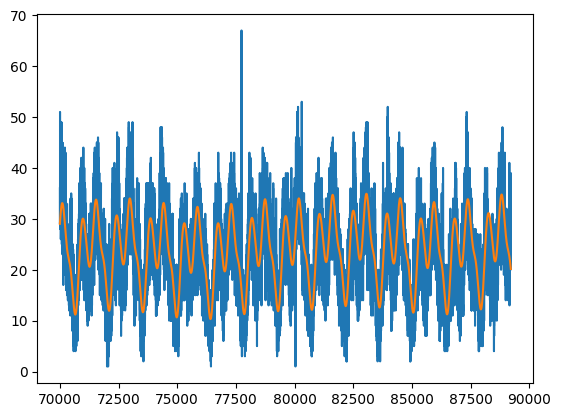

In [78]:
import matplotlib.pyplot as plt

plt.plot(np.arange(X.shape[0])[70000:], y[70000:])
plt.plot(np.arange(70000, X.shape[0]), pred_y)

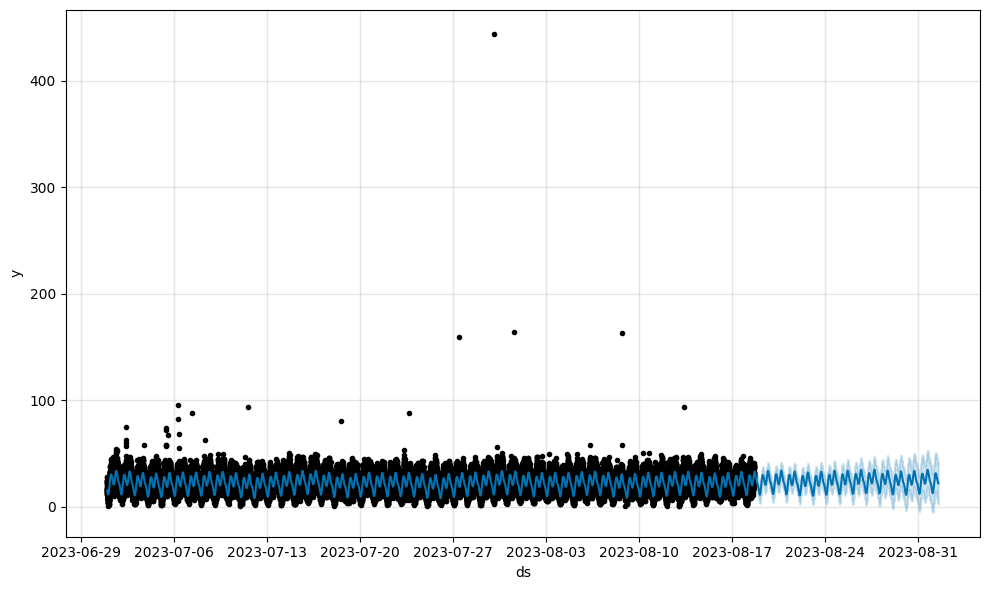

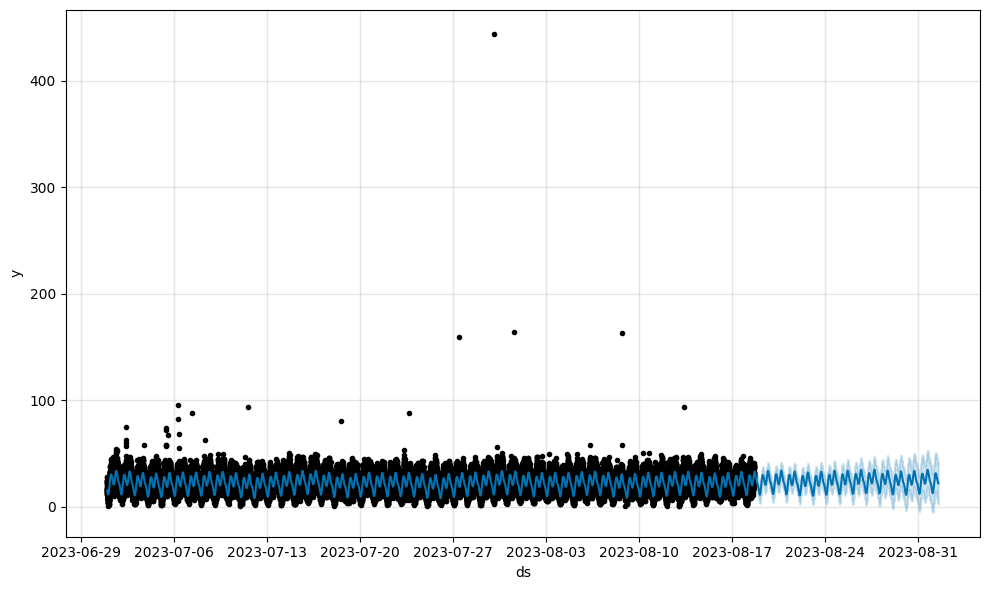

In [61]:
m.plot(forecast)